# Step 1: Import Libraries and Load the Dataset

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeRegressor


# load dataset
diabetes = load_diabetes(as_frame=True, scaled=False)

x = diabetes.data
y = diabetes.target

print(x.head())
print(y.head())

#optional
# print(diabetes.DESCR)


    age  sex   bmi     bp     s1     s2    s3   s4      s5    s6
0  59.0  2.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0
1  48.0  1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0
2  72.0  2.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0
3  24.0  1.0  25.3   84.0  198.0  131.4  40.0  5.0  4.8903  89.0
4  50.0  1.0  23.0  101.0  192.0  125.4  52.0  4.0  4.2905  80.0
0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64


# Frame the Problem

Predict **diabetes progression one year after baseline**

    -**Target variable:** disease progression(continous)
    -**Features:** 10 physilogical measurements(age, sex, BMI, blood preassure, bloo serum metrics)\
    -**Problem type:** Regression
    -**Evaluation metrics** R², MAE, MAPE

# review this more



In [32]:
# dataset dimensions

print("Feature matrix shape:", x.shape)
print("Target vector shape:", y.shape)


Feature matrix shape: (442, 10)
Target vector shape: (442,)


# Step 3: Exploratory Data Analysis

Objectives:
1. Summary statistics
2. Feature distributions
3. Feature-target relationships
4. Correlation matrix
5. Insights for modeling

              age         sex         bmi          bp          s1          s2  \
count  442.000000  442.000000  442.000000  442.000000  442.000000  442.000000   
mean    48.518100    1.468326   26.375792   94.647014  189.140271  115.439140   
std     13.109028    0.499561    4.418122   13.831283   34.608052   30.413081   
min     19.000000    1.000000   18.000000   62.000000   97.000000   41.600000   
25%     38.250000    1.000000   23.200000   84.000000  164.250000   96.050000   
50%     50.000000    1.000000   25.700000   93.000000  186.000000  113.000000   
75%     59.000000    2.000000   29.275000  105.000000  209.750000  134.500000   
max     79.000000    2.000000   42.200000  133.000000  301.000000  242.400000   

               s3          s4          s5          s6  
count  442.000000  442.000000  442.000000  442.000000  
mean    49.788462    4.070249    4.641411   91.260181  
std     12.934202    1.290450    0.522391   11.496335  
min     22.000000    2.000000    3.258100   58

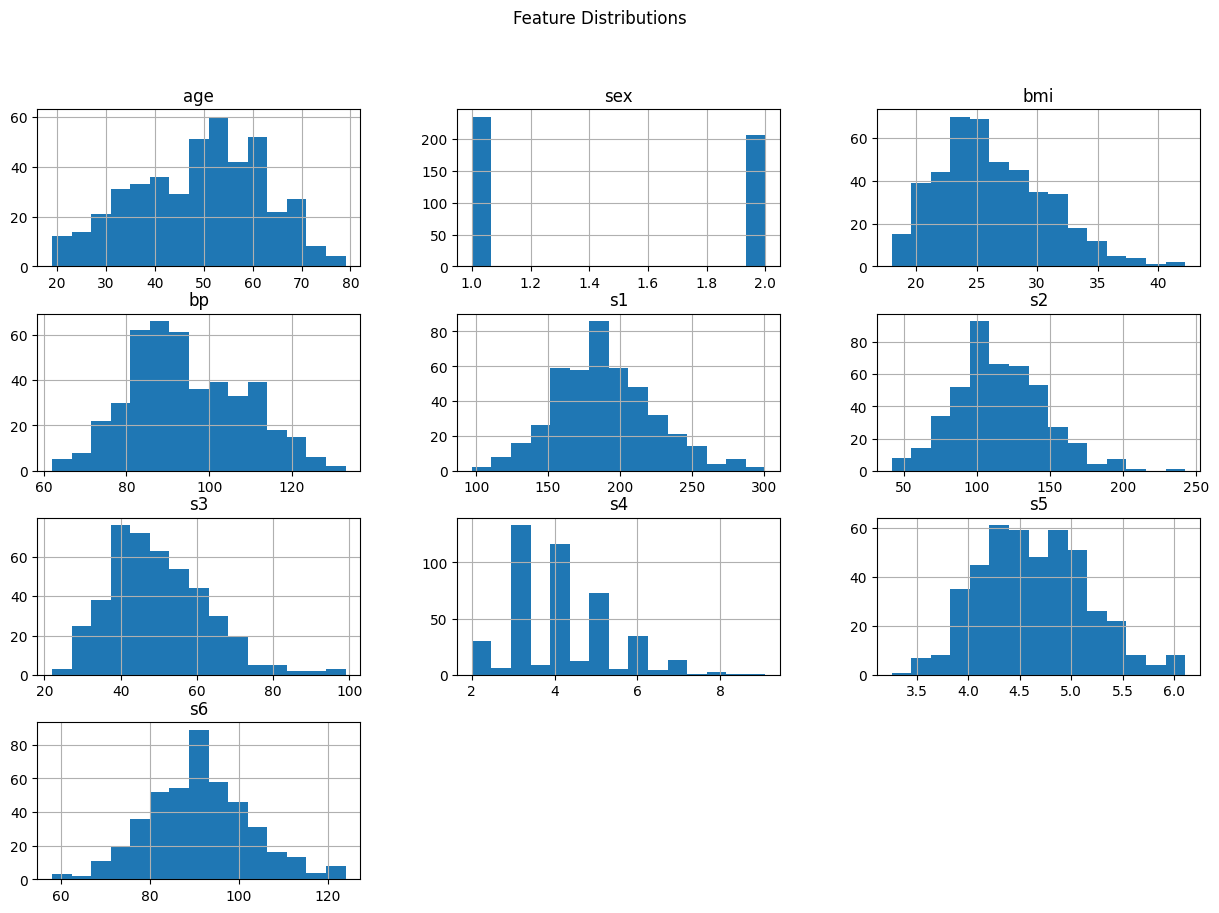

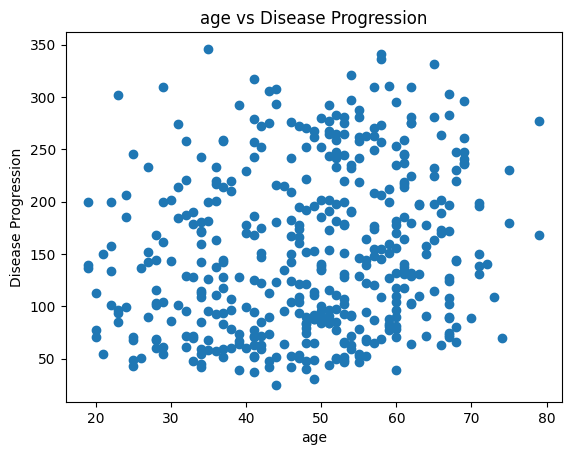

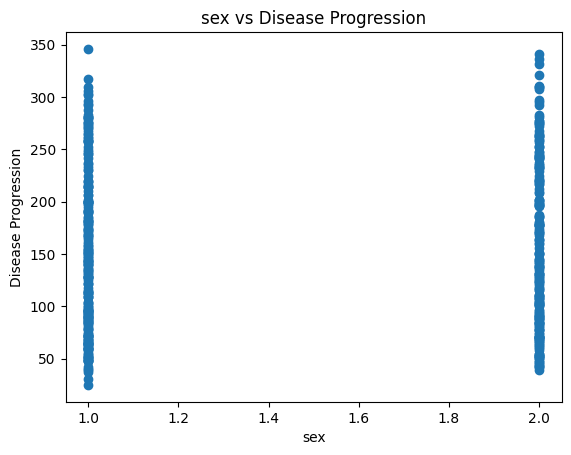

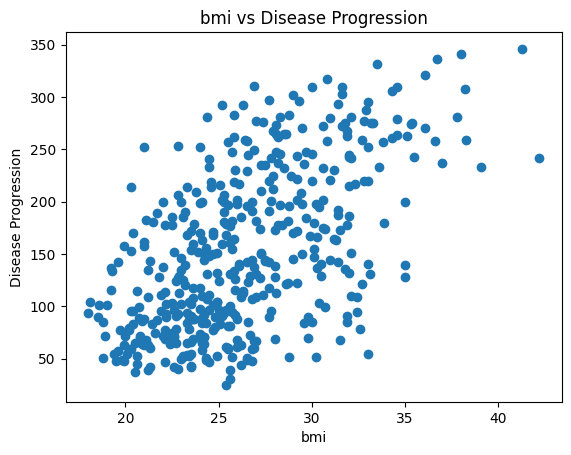

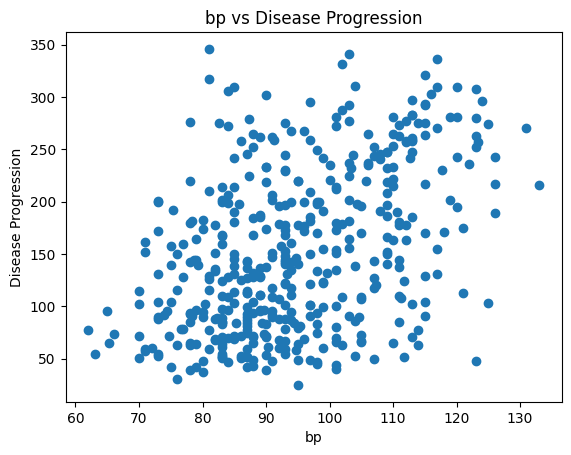

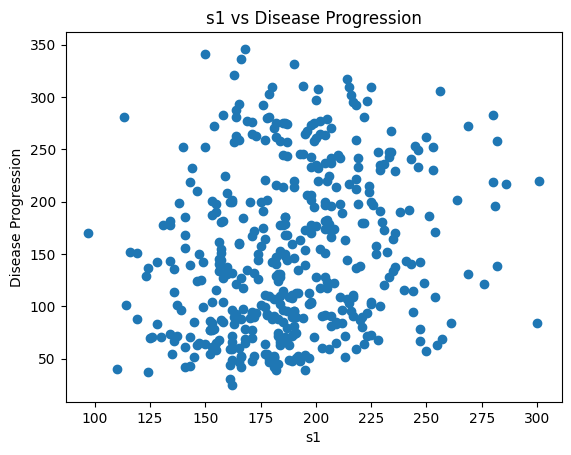

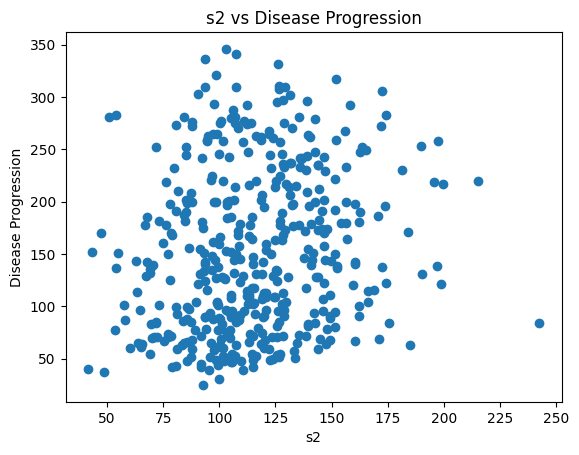

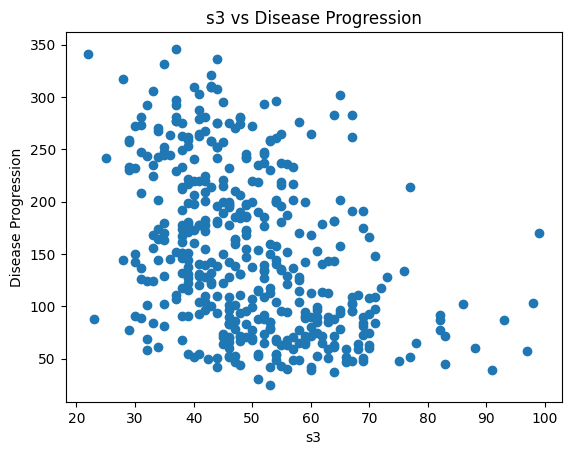

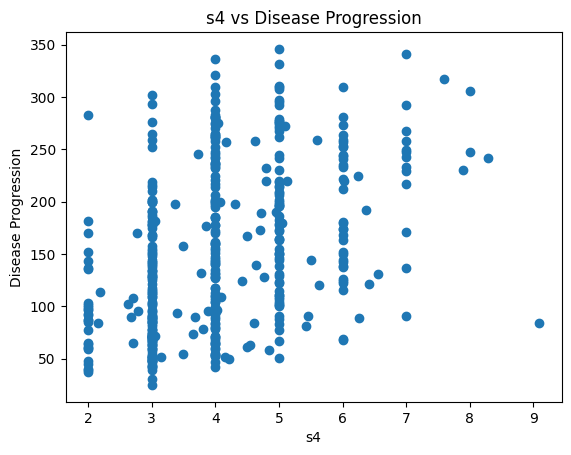

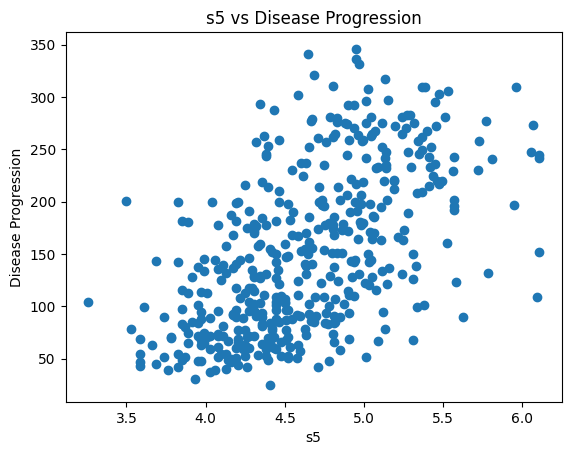

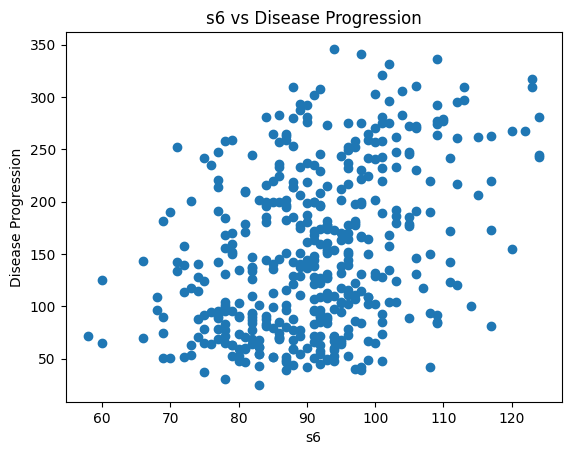

<Axes: >

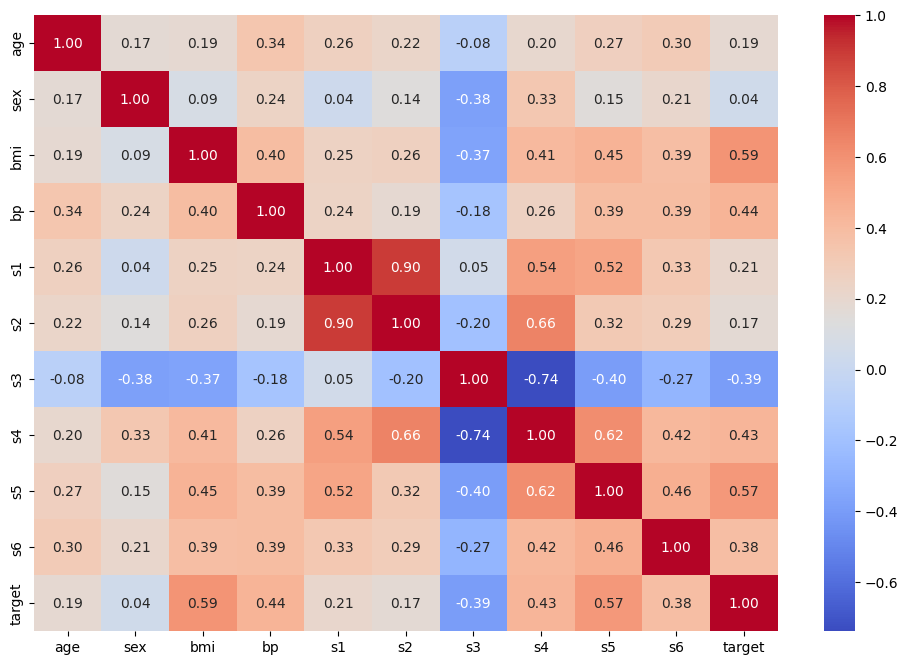

In [33]:
# Summary statistics

print(x.describe())
print("\nTarget variable statistics:")
print(y.describe())

#Histograms
x.hist(bins=15, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()



# Scatter plots of features vs target

for col in x.columns:
    plt.figure()
    plt.scatter(x[col], y)
    plt.title(f"{col} vs Disease Progression")
    plt.xlabel(col)
    plt.ylabel("Disease Progression")
    plt.show()


# Correlation matrix

corr_matrix = x.copy()
corr_matrix["target"] = y
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix.corr(), annot=True, cmap="coolwarm", fmt=".2f")

# Step 4: Data Cleaning

Checks:
- Missing values
- Outliers
- Feature scaling

Rationale: Ensure reliable modeling and reproducibility

Missing values in features:
 age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64
Missing values in target:
 0


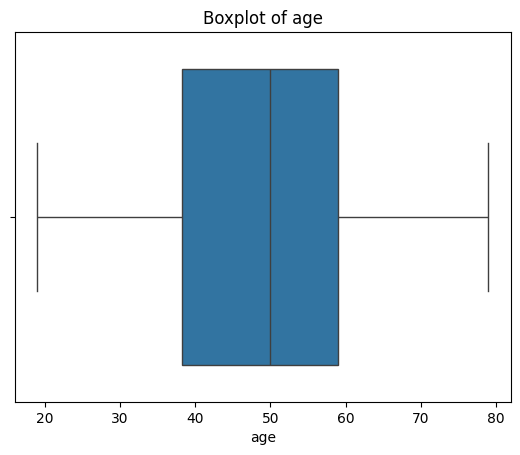

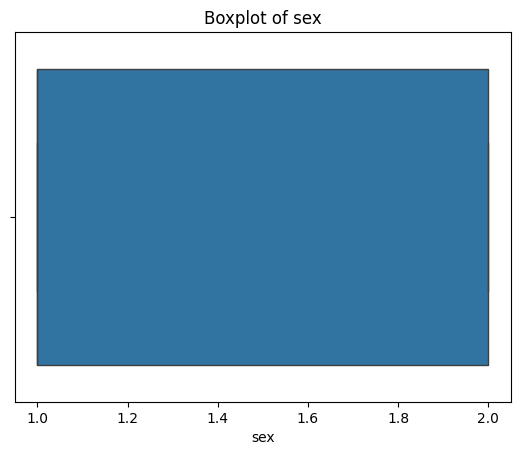

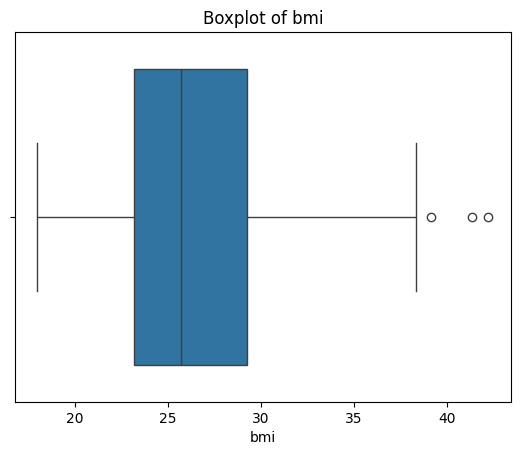

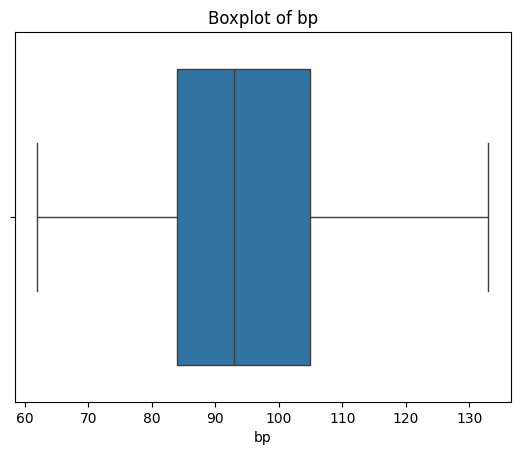

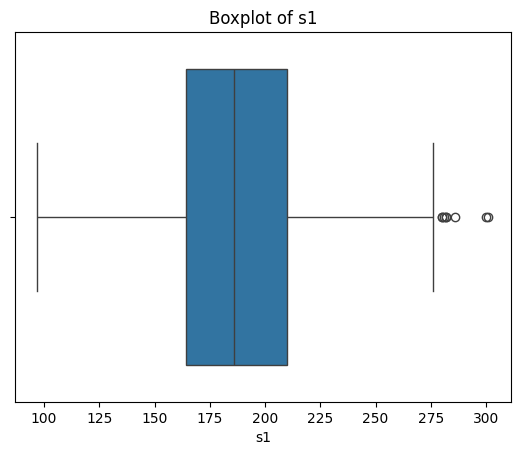

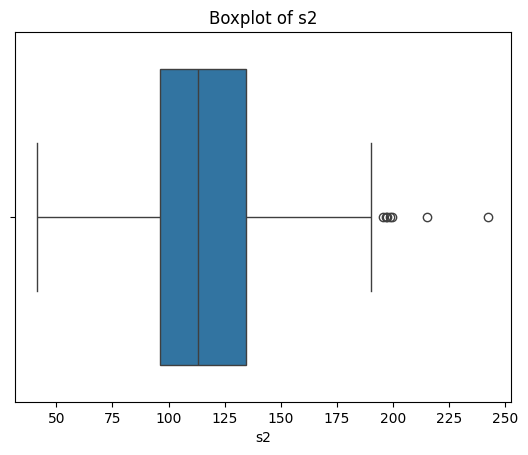

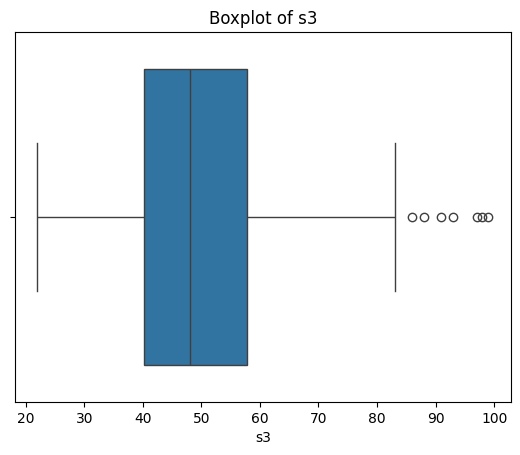

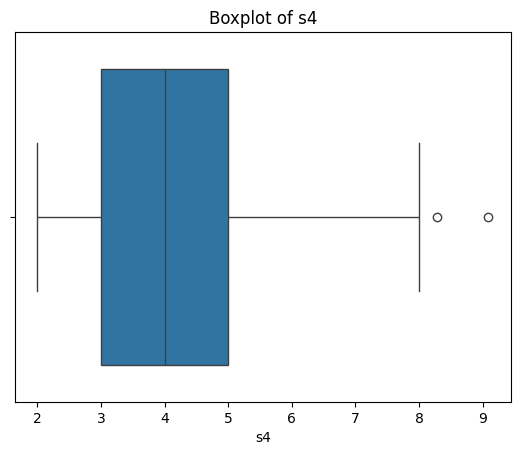

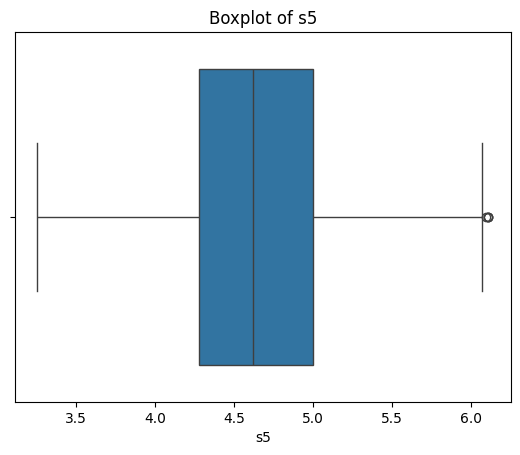

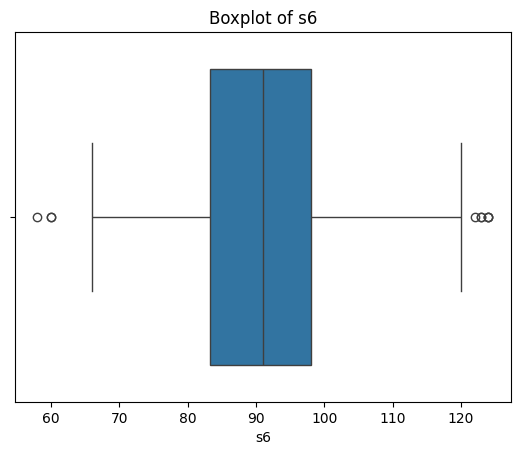

In [34]:
# check for missing values

print("Missing values in features:\n", x.isna().sum())
print("Missing values in target:\n", y.isna().sum())


# Boxplots to inspect outliers

for col in x.columns:
    plt.figure()
    sns.boxplot(x=x[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# Step 5: Split dataset

- Training: 75%
- Validation: 10%
- Test: 15%

Use of "train_test_split" twice to maintain the proportions and reproducibility with random_state=42"

In [35]:
# Try to find a way without random_state=42

#First split: train (75%) and temp (25%)

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.25, random_state=42)


#Second split: validation 10% and test (15%)
val_size = 0.10/0.25
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=1-val_size, random_state=42)


# Check shapes

print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)
print("Test set:", x_test.shape, y_test.shape)


Training set: (331, 10) (331,)
Validation set: (44, 10) (44,)
Test set: (67, 10) (67,)


Part 2: Univariate Polynomial Regression

Step 6: Univariate Polynomial Regression on BMI

Use BMI to predict diabetes progression

Polynomial degrees 0-5(six models)
Fit each model ad store results for comparison

In [36]:
# Extract BMI feature

x_train_bmi = x_train[["bmi"]]
x_val_bmi = x_val[["bmi"]]
x_test_bmi = x_test[["bmi"]]

# Store models and results

models = {}
results = []


for degree in range(6):
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    x_train_poly = poly.fit_transform(x_train_bmi)
    x_val_poly = poly.fit_transform(x_val_bmi)

    model= LinearRegression()
    model.fit(x_train_poly, y_train)

    models[degree] = (model, poly)

    y_train_pred = model.predict(x_train_poly)
    y_val_pred = model.predict(x_val_poly)

    results.append({
        "Degree": degree,
        "Train R2": r2_score(y_train, y_train_pred),
        "Validation R2": r2_score(y_val, y_val_pred),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Validation MAE": mean_absolute_error(y_val, y_val_pred),
        "Train MAPE": np.mean(np.abs((y_train - y_train_pred) / y_train)) *100,
        "Validation MAPE": np.mean(np.abs((y_val - y_val_pred) / y_val)) *100,
    })

# Step 7: Compare Polynomial Models

Summary of performance (R², MAE, MAPE) for each polynomial degree.

In [37]:
results_df = pd.DataFrame(results)
results_df = results_df[["Degree", "Train R2", "Validation R2", "Train MAE", "Validation MAE", "Train MAPE", "Validation MAPE" ]]
print(results_df)

   Degree  Train R2  Validation R2  Train MAE  Validation MAE  Train MAPE  \
0       0  0.000000      -0.106957  66.201641       66.057059   62.826669   
1       1  0.349672       0.331264  52.287739       47.208472   48.362886   
2       2  0.350764       0.331631  52.207314       47.213700   48.298534   
3       3  0.350774       0.331638  52.198968       47.185414   48.280744   
4       4  0.353014       0.340758  52.092653       46.090118   48.053266   
5       5  0.354100       0.349881  52.059191       45.462122   48.004022   

   Validation MAPE  
0        71.263880  
1        47.060009  
2        47.239667  
3        47.222673  
4        46.050330  
5        45.175276  


# Step 8 Identify the Best Model

Choose the model wit the highest validation R² while keep errors reasonable

In [38]:
best_degree = results_df.loc[results_df["Validation R2"].idxmax(), "Degree"]
best_model, best_poly = models[best_degree]
print(f"Best polynomial degree: {best_degree}")



Best polynomial degree: 5


# Step 9: Evaluate on Test set

In [39]:
x_test_poly = best_poly.transform(x_test_bmi)
y_test_pred = best_model.predict(x_test_poly)

test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"Test R2: {test_r2:.3f}, Test MAE: {test_mae:.3f}, Test MAPE: {test_mape:.2f}%")

Test R2: 0.267, Test MAE: 51.750, Test MAPE: 43.03%


# Step 10: Plot Model

Train, Validation, test points with fitted curve

C:\Users\jjbed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


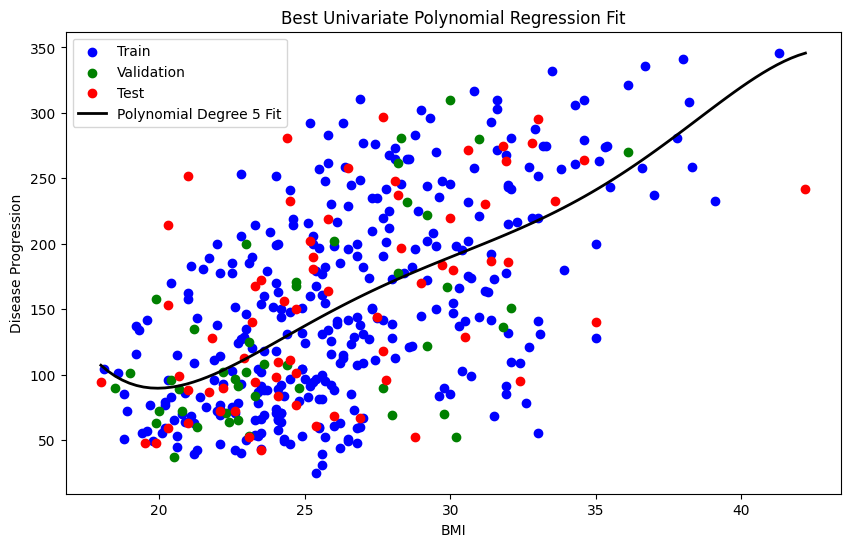

In [40]:

#Define x_bmi

x_bmi = x["bmi"]


#Make sure train, val, test bmi splits exist
x_train_bmi = x_train[["bmi"]]
x_val_bmi = x_val[["bmi"]]
x_test_bmi = x_test[["bmi"]]



bmi_range = np.linspace(x_bmi.min(), x_bmi.max(), 100).reshape(-1,1)
bmi_range_poly = best_poly.transform(bmi_range)
pred_curve = best_model.predict(bmi_range_poly)

plt.figure(figsize=(10,6))
plt.scatter(x_train_bmi, y_train, color="blue", label="Train")
plt.scatter(x_val_bmi, y_val, color='green', label='Validation')
plt.scatter(x_test_bmi, y_test, color='red', label='Test')
plt.plot(bmi_range, pred_curve, color='black', linewidth=2, label=f'Polynomial Degree {best_degree} Fit')
plt.xlabel("BMI")
plt.ylabel("Disease Progression")
plt.title("Best Univariate Polynomial Regression Fit")
plt.legend()
plt.show()

Step 11: Equation of Best Model

In [41]:
coefs = best_model.coef_
intercept = best_model.intercept_
terms = [f"{intercept:.2f}"] + [f"{coefs[i]:.2f}*x^{i}" for i in range (1, len(coefs))]
equation = " + ".join(terms)
print(f"Equation: y = {equation}")
#highlight

Equation: y = 10409.75 + -1809.22*x^1 + 123.57*x^2 + -4.12*x^3 + 0.07*x^4 + -0.00*x^5


# Step 12: Predict Diabetes Progression for a BMI value



In [42]:
chosen_bmi = np.array([[30]])
chosen_bmi_poly = best_poly.transform(chosen_bmi)
predicted_progression = best_model.predict(chosen_bmi_poly)
print(f"Predicted progression for BMI=30: {predicted_progression[0]:.2f}")

Predicted progression for BMI=30: 189.70


C:\Users\jjbed\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


# Step 13: Trainable parameters

Number of trainable coefficients equals number of polynomial features

In [43]:
print("Polynomial features:", best_poly.get_features_names_out())
print(f"Number of trainable parameters: {len(best_poly.get_feature_names_out())}")

#highlight

AttributeError: 'PolynomialFeatures' object has no attribute 'get_features_names_out'

# Step 14: Conclusion

- Best degree: {best_degree}, with metrics summarized above.
- Limitations: univariate model ignores interactions with other features.
- Errors may be large for extreme BMI values.
- Takeaways: compare train/validation performance, consider multivariate models for better predictions.
#HIghliht do

#Step 15: Multivaraite Polynomial Regression

Use features to build polynomial regression models (degrees 2 and 3).
Evaluate R², MAE, and MAPE on train, validation, and test sets.

In [ ]:
poly_degrees = [2,3]
multi_models = {}
multi_results = []

x_train_multi = x_train.copy()
x_val_multi = x_val.copy()
x_test_multi = x_test.copy()

for degree in poly_degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    x_train_poly = poly.fit_transform(x_train_multi)
    x_val_poly = poly.transform(x_val_multi)
    x_test_poly = poly.transform(x_test_multi)

    model = LinearRegression()
    model.fit(x_train_poly, y_train)
    multi_models[degree] = (model, poly)

    y_train_pred = model.predict(x_train_poly)
    y_val_pred = model.predict(x_val_poly)
    y_test_pred = model.predict(x_test_multi)


    multi_results.append({
        "Degree": degree,
        "Train R2": r2_score(y_train, y_train_pred),
        "Validation R2": r2_score(y_val, y_val_pred),
        "Test R2": r2_score(y_test, y_test_pred),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Validation MAE": mean_absolute_error(y_val, y_val_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Train MAPE": np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100,
        "Validation MAPE": np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100,
        "Test MAPE": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    })

pd.DataFrame(multi_results)




# Step 16: Decision Trees

In [ ]:
tree_depths = [3,6]
tree_models = {}
tree_results = []

for depth in tree_depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42) #highlight
    tree.fit(x_train_multi, y_train)
    tree_models[depth] = tree

    y_train_pred = tree.predict(x_train_multi)
    y_val_pred = tree.predict(x_val_multi)
    y_test_pred = tree.predict(x_test_multi)

    tree_results.append({
        "Max Depth": depth,
        "Train R2": r2_score(y_train, y_train_pred),
        "Validation R2": r2_score(y_val, y_val_pred),
        "Test R2": r2_score(y_test, y_test_pred),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Validation MAE": mean_absolute_error(y_val, y_val_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Train MAPE": np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100,
        "Validation MAPE": np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100,
        "Test MAPE": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    })

pd.DataFrame(tree_results)


# Step 17: K-nearest Neihbors (kNN)

Build two kNN models with different k values. Since kNN is distance based, we scale features using StandardScaler


In [ ]:
# scale features

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_multi)
x_val_scaled = scaler.transform(x_val_multi)
x_test_scaled = scaler.transform(x_test_multi)

k_values = [3,7]
knn_models = {}
knn_results = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train_scaled, y_train)
    knn_models[k] = knn

    y_train_pred = knn.predict(x_train_scaled)
    y_val_pred = knn.predict(x_val_scaled)
    y_test_pred = knn.predict(x_test_scaled)

    knn_results.append({
        "k": k,
        "Train R2": r2_score(y_train, y_train_pred),
        "Validation R2": r2_score(y_val, y_val_pred),
        "Test R2": r2_score(y_test, y_test_pred),
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Validation MAE": mean_absolute_error(y_val, y_val_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Train MAPE": np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100,
        "Validation MAPE": np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100,
        "Test MAPE": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    })

pd.DataFrame(knn_results)

# Step 18: Logistic Regression

Convert the continuous target to a 1 or 0 (binary variable). Build two Logistic Regression models with different regularization strengths

In [ ]:
# Binarize target (above/below median)

y_train_bin = (y_train > y_train.median()).astype(int)
y_val_bin = (y_val > y_val.median()).astype(int)
y_test_bin = (y_test > y_test.median()).astype(int)

c_values = [0.1, 1]
log_models = {}
log_results = []

for c in c_values:
    logreg = LogisticRegression(C=c, max_iter=1000)
    logreg.fit(x_train_scaled, y_train_bin)
    log_models[c] = logreg

    y_train_pred = logreg.predict(x_train_scaled)
    y_val_pred = logreg.predict(x_val_scaled)
    y_test_pred = logreg.predict(x_test_scaled)

    log_results.append({
        "C": c,
        "Train Accuracy": accuracy_score(y_train_bin, y_train_pred),
        "Validation Accuracy": accuracy_score(y_val_bin, y_val_pred),
        "Test Accuracy": accuracy_score(y_test_bin, y_test_pred),
        "Train Precision": precision_score(y_train_bin, y_train_pred),
        "Validation Precision": precision_score(y_val_bin, y_val_pred),
        "Test Precision": precision_score(y_test_bin, y_test_pred),
        "Train Recall": recall_score(y_train_bin, y_train_pred),
        "Validation Recall": recall_score(y_val_bin, y_val_pred),
        "Test Recall": recall_score(y_test_bin, y_test_pred)
    })

pd.DataFrame(log_results)

# Step 19 Part 3 Conclusion

# ** Highlight **
**Polynomial Regression (Multivariate)**
- Degrees 2 and 3 include feature interactions
- Can improve R² over univariate model but it might overfit

**Decision Trees**
- Captures non-linearities
- Deeper trees can fit training data better, but it might overfit
**kNN**
- May be Sensitive to feature scaling
- Choice of "k" affects bias-variance tradeoff

**Logistic Regression**
- Shows classification potential if target is binarized
- Can be limited for continuous regression tasks

**Limitations Across Models**
- Polynomial models: feature explosion, might cause difficulty in interpretability
- Decision Trees/kNN: may be sensitive to outliers/noise
- Logistic Regression: not for continuous outcomes